In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
from scipy.interpolate import interp1d
import pickle

In [74]:
def conv(signal, kernel):
    signal_length = len(signal)
    kernel_length = len(kernel)
    output_length = signal_length - kernel_length + 1
    result = np.zeros(output_length)

    for i in range(output_length):
        signal_slice = signal[i:i + kernel_length]
        norm_signal_slice = signal_slice / np.linalg.norm(signal_slice)
        norm_kernel = kernel / np.linalg.norm(signal_slice)
        
        result[i] = np.dot(norm_signal_slice, norm_kernel)
        
    return result

In [75]:
def amplitude_in_band(conv_res, min_fr, max_fr):
    frequencies, times, Zxx = signal.stft(
        conv_res,
        fs=64,
        window='hann',
        nperseg=256,
        noverlap=250
    )

    freq_mask = (frequencies >= min_fr) & (frequencies <= max_fr)

    amplitude_in_band = np.mean(np.abs(Zxx[freq_mask, :]), axis=0)

    return amplitude_in_band


In [76]:
def create_mask(min_amplitude, max_amplitude, min_len_interval, amplitude_in_band, len_ppg):
    cross_above_min = np.where((amplitude_in_band[:-1] < min_amplitude) & (amplitude_in_band[1:] >= min_amplitude))[0] + 1
    cross_below_min = np.where((amplitude_in_band[:-1] >= min_amplitude) & (amplitude_in_band[1:] < min_amplitude))[0] + 1

    intervals = []
    start = None
    
    if amplitude_in_band[0] >= min_amplitude:
        start = 0
        
    for i in range(len(cross_above_min)):
        start = cross_above_min[i]
        
        end_candidates = cross_below_min[cross_below_min > start]
        if len(end_candidates) == 0:
            break
        end = end_candidates[0]
        
        intervals.append((start, end))
        
        start = None

    valid_intervals = []
    for start, end in intervals:
        if np.any(amplitude_in_band[start:end] > max_amplitude) or ((end - start) < min_len_interval):
            continue
        valid_intervals.append((start, end))

    time_mask = np.zeros_like(amplitude_in_band, dtype=bool)
    for start, end in valid_intervals:
        time_mask[start:end] = True


    # kernel = np.ones(10)
    # time_mask = binary_closing(time_mask, kernel)
    # time_mask_clean = binary_opening(time_mask, kernel)

    indices_mask = np.arange(len(time_mask))
    indices_ppg = np.linspace(0, len(time_mask) - 1, len_ppg)

    mask_func = interp1d(
        indices_mask,
        time_mask,
        kind='nearest',
        bounds_error=False,
        fill_value=False
    )

    full_mask = mask_func(indices_ppg).astype(bool)

    return full_mask


In [77]:
def drow_data(ppg, person_name, status):
    if len(ppg) > 0:
        wigth = len(ppg) // 64
        figr = plt.figure(figsize=(wigth, 6))
        plt.plot(ppg)
        plt.grid(True)  
        plt.ylim(-40, 40)
        plt.savefig(f'/home/ilya/Documents/stress-level-by-PPG/filt_data/{person_name}_{status}.png', dpi=300, bbox_inches='tight')
        plt.close(figr)


In [78]:
def filt_data(ppg, min_fr, max_rf, min_amp, max_amp, min_interval_len):
    reference_wave = np.load('./reference_wave.npy')
    conv_res = conv(ppg, reference_wave)
    res_amplitude = amplitude_in_band(conv_res, min_fr, max_rf)
    mask = create_mask(min_amp, max_amp, min_interval_len, res_amplitude, len(ppg))
    filt_ppg = ppg[mask]

    return filt_ppg

In [79]:
min_fr = 1
max_rf = 2
min_amp = 0.08
max_amp = 0.23
min_interval_len = 128

In [80]:
data = pd.read_pickle(f'/home/ilya/Documents/stress-level-by-PPG/data.pkl')

In [81]:
filt_dataset = dict()

In [92]:
for person_name, person_data in data.items():
    ppg_stress = person_data['PPG_stress']
    ppg_medit = person_data['PPG_medit']

    filt_ppg_stress = filt_data(ppg_stress, min_fr, max_rf, min_amp, max_amp, min_interval_len)
    filt_ppg_medit = filt_data(ppg_medit, min_fr, max_rf, min_amp, max_amp, min_interval_len)

    # drow_data(filt_ppg_stress, person_name, "st")
    # drow_data(filt_ppg_medit, person_name, "md")

    filt_dataset[person_name] = dict(
        {
        'PPG_stress': filt_ppg_stress,
        'stress_lvl_for_stress': person_data["stress_lvl_for_stress"],
        'PPG_medit': filt_ppg_medit,
        'stress_lvl_for_medit': person_data["stress_lvl_for_medit"]
        }
    )


In [95]:
with open('./filt_dataset.pkl', 'wb') as file:
    pickle.dump(filt_dataset, file)

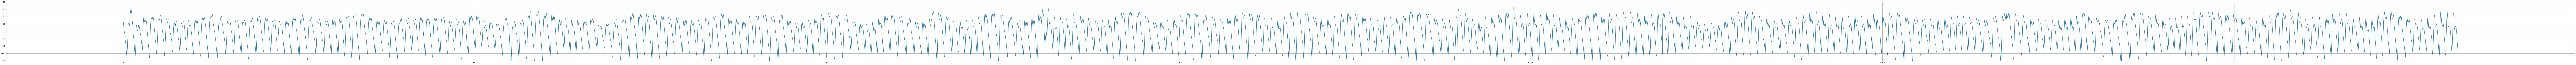

In [96]:
filt_data_ = pd.read_pickle(f'/home/ilya/Documents/stress-level-by-PPG/filt_dataset.pkl')

wigth = len(filt_data_["S10"]["PPG_medit"]) // 64
plt.figure(figsize=(wigth, 6))
plt.plot(filt_data_["S10"]["PPG_medit"])
plt.grid(True)  
plt.ylim(-40, 40)
plt.show()

In [85]:
# test_ppg = data['S5']['PPG_stress']
# conv_res = conv(test_ppg, reference_wave)
# res_amplitude = amplitude_in_band(conv_res, min_fr, max_rf)
# mask = create_mask(min_amp, max_amp, min_interval_len, res_amplitude, len(test_ppg))
# filt_ppg = test_ppg[mask]

# plt.figure(figsize=(200, 12))

# plt.subplot(4, 1, 1)
# plt.plot(test_ppg)
# plt.ylim(-100, 100)
# plt.grid(True)

# plt.subplot(4, 1, 2)
# plt.plot(conv_res)
# plt.ylim(-2, 2)
# plt.grid(True)

# plt.subplot(4, 1, 3)
# plt.plot(res_amplitude)
# plt.plot([min_amp] * len(res_amplitude))
# plt.plot([max_amp] * len(res_amplitude))
# plt.ylim(0, 1)
# plt.grid(True)

# plt.subplot(4, 1, 4)
# plt.plot(mask)
# plt.ylim(-1, 2)

# plt.savefig(f'/home/ilya/Documents/stress-level-by-PPG/ppg-conv-ampl-mask.png', dpi=300, bbox_inches='tight')
# plt.show()

In [86]:
# filt_ppg = ppg[mask]

# plt.figure(figsize=(50, 4))
# plt.plot(filt_ppg)
# plt.grid(True)
# plt.savefig(f'./res_filt_signal.png', dpi=300, bbox_inches='tight')